### This notebook shows training process for Age & Gender classification task

I will use simple CNN model (no SoTA face recognition backbone and whatsoever, just resnet/mobilenet fine-tuned from imagenet weights)

In [18]:
# install needed packages
!pip install torch numpy opencv-python matplotlib albumentations

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

import sys
import time
from pathlib import Path
import json
import matplotlib.pyplot as plt
%matplotlib inline

import albumentations as albu
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2

# fix random seed
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"python version {sys.version}, pytorch version {torch.__version__}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name('cuda')}")

python version 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0], pytorch version 1.11.0
GPU: Tesla P100-PCIE-16GB


Straight into action: for better performing model we need regularization, I achieve that using augmentations

[Albumentations](https://github.com/albumentations-team/albumentations) is the great library

For gender & age prediction I can use most of the transforms, except rotation and cropping (because I already have cropped faces in the dataset)

Also I decided not to use elastic transforms as they consume too much cpu power

In [21]:
ROOT = Path("/kaggle/input/adiencegender/AdienceGender/aligned")
kroot = Path("/kaggle/working")
labels = json.load(kroot.joinpath("labels.json").open())

In [22]:
def show_img(image):
    plt.figure(figsize=(12, 10))
    plt.imshow(image)
    plt.show()

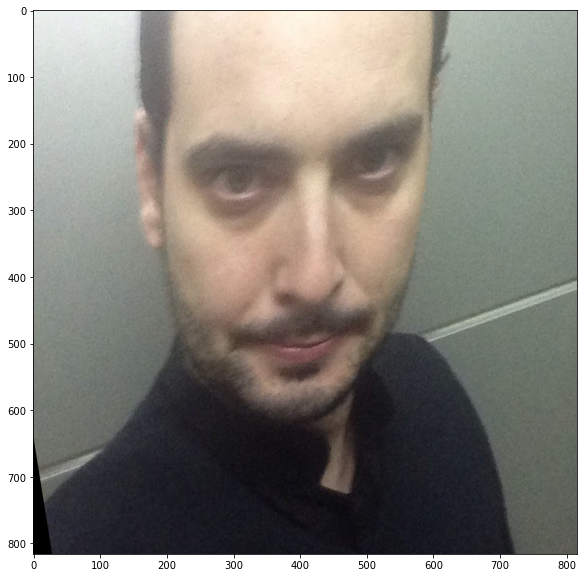

In [23]:
im = cv2.imread(str(ROOT.joinpath(list(labels)[500])))[..., ::-1]
show_img(im)

In [24]:
# define train transforms and valid transforms

# height, width
image_size = (224, 224)

augmentations = [
    albu.RandomResizedCrop(*image_size, scale=(0.6, 1)),
    albu.HorizontalFlip(),
    albu.RandomBrightnessContrast(),
    albu.OneOf([
        albu.CLAHE(),
        albu.Blur(5),
        albu.RGBShift()  
    ], p=1),
]

# for debugging purposes only
show_transforms = albu.Compose(augmentations)

train_transforms = albu.Compose([
    *augmentations,
    albu.Normalize(),
    ToTensorV2()
])

valid_transforms = albu.Compose([
    albu.Resize(*(np.array(image_size) * 1.25).astype(int)),
    albu.CenterCrop(*image_size),
    albu.Normalize(),
    ToTensorV2()
])

In [25]:
%%timeit
transformed = show_transforms(image=im)['image']

6.59 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


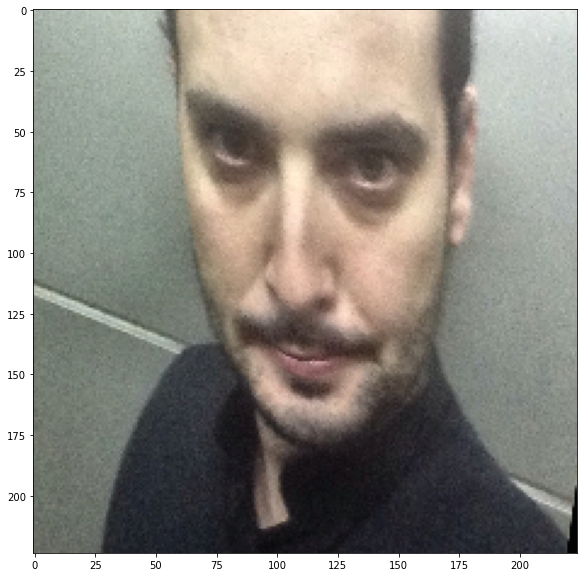

In [26]:
show_img(show_transforms(image=im)['image'])

In [27]:
class AgeGenderDataset(Dataset):
    """Very simple dataset for age&gender task"""
    def __init__(self, root, items, transform):
        self.root = root
        self.items = items
        self.transform = transform
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        filepath, meta = self.items[idx]
        img = cv2.imread(str(self.root.joinpath(filepath)))[..., ::-1]
        img = self.transform(image=img)['image']
        age_id, gender_id = torch.tensor(meta['age_id']), torch.tensor(meta['gender_id'])
        return img, (age_id, gender_id)


In [28]:
class AgeGenderModel(nn.Module):
    """
    CNN model with 2 heads and SE-block
    with multitask model learns faster
    """
    def __init__(self, encoder, encoder_channels, 
                 age_classes, gender_classes, output_channels=512):
        super().__init__()
        
        # encoder features (resnet50 in my case)
        # output should be bs x c x h x w
        self.encoder = encoder
        
        # sqeeze-excite
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.downsample = nn.Conv2d(encoder_channels, output_channels, 1)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.nonlin1 = nn.ReLU()
        
        self.excite = nn.Conv2d(output_channels, output_channels, 1)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.nonlin2 = nn.ReLU()
        
        self.age_head = nn.Conv2d(output_channels, age_classes, 1)
        self.gender_head = nn.Conv2d(output_channels, gender_classes, 1)
    
    def forward(self, x):
        features = self.encoder(x)
        features = self.squeeze(features)
        features = self.downsample(features)
        features = self.nonlin1(self.bn1(features))
        
        weights_logits = self.excite(features)
        features = features * weights_logits.sigmoid()
        features = self.nonlin2(self.bn2(features))
        
        age_logits = self.age_head(features).view(features.size(0), -1)
        gender_logits = self.gender_head(features).view(features.size(0), -1)
        return age_logits, gender_logits
    

In [29]:
VALID_AMOUNT = 0.1
batch_size = 96

# labels for data
items = np.array(list(labels.items()))
valid_idx = np.random.randint(len(items), size=int(VALID_AMOUNT * len(items)))
train_idx = np.array([i for i in np.arange(len(items)) if not (i == valid_idx).any()])

train_loader = DataLoader(
    AgeGenderDataset(ROOT, items[train_idx], train_transforms),
    batch_size,
    shuffle=True,
    num_workers=8
)

valid_loader = DataLoader(
    AgeGenderDataset(ROOT, items[valid_idx], valid_transforms),
    batch_size,
    shuffle=False,
    num_workers=4
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [30]:
def accuracy(pred: torch.Tensor, gt: torch.Tensor):
    """
    accuracy metric
    
    expects pred shape bs x n_c, gt shape bs x 1
    """
    return (pred.max(1)[1] == gt).float().mean()

In [31]:
def train(model, loader, opt, 
          age_criterion, gender_criterion, metric_fn, 
          device="cuda", sched=None, epoch=1, print_every=50):
    model.train()
    t0 = time.time()
    for batch_idx, (image, (age_gt, gender_gt)) in enumerate(loader):
        data_time = time.time() - t0
        opt.zero_grad()
        t1 = time.time()
        image, age_gt, gender_gt = image.to(device), age_gt.to(device), gender_gt.to(device)
        age_logits, gender_logits = model(image)
        
        # BCE expects one-hot vector
        age_gt_onehot = torch.zeros(*age_logits.size(), device=age_logits.device)
        age_gt_onehot = age_gt_onehot.scatter_(1, age_gt.unsqueeze(-1).long(), 1)
        gender_gt = gender_gt.long()
        
        model_time = time.time() - t1
        loss_age = age_criterion(age_logits, age_gt_onehot)  # bce
        loss_gender = gender_criterion(gender_logits, gender_gt)  # softmax+ce
        loss = (loss_age + loss_gender) / 2
        loss.backward()
        opt.step()
        if sched is not None:
            sched.step()
        gender_acc = metric_fn(gender_logits, gender_gt)
        age_acc = metric_fn(age_logits, age_gt)
        
        if batch_idx % print_every == 0:
            print(f"train epoch {epoch}, {batch_idx} / {len(loader)}, loss age {loss_age.item():.3f} "
                  f"loss gender {loss_gender.item():.3f} loss: {loss.item():.3f}, "
                  f"gender acc: {gender_acc.item():.2%} age acc: {age_acc.item():.2%} "
                  f"data/model times {data_time*1000:.1f} ms, {model_time*1000:.1f} ms")
        t0 = time.time()
        

def validate(model, loader, metric_fn, device="cuda", epoch=1):
    model.eval()
    gender_acc_list = []
    age_acc_list = []
    for image, (age_gt, gender_gt) in loader:
        with torch.no_grad():
            image, age_gt, gender_gt = image.to(device), age_gt.to(device), gender_gt.to(device)
            age_logits, gender_logits = model(image)
            gender_acc_list.append(metric_fn(gender_logits, gender_gt).item())
            age_acc_list.append(metric_fn(age_logits, age_gt).item())
    gender_acc = np.mean(gender_acc_list)
    age_acc = np.mean(age_acc_list)
    print(f"val epoch {epoch}, gender acc {gender_acc:.2%}, age acc {age_acc:.2%}")
    return (gender_acc + age_acc) / 2

In [32]:
resnet50_encoder = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])
model = AgeGenderModel(resnet50_encoder, 2048, age_classes=8, gender_classes=3).cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [33]:
num_epochs = 10
lr = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
age_criterion = nn.BCEWithLogitsLoss()
gender_criterion = nn.CrossEntropyLoss()

In [34]:
for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer, 
          age_criterion, gender_criterion, metric_fn=accuracy, 
          device="cuda", epoch=epoch, print_every=30)
    val_acc = validate(model, valid_loader, metric_fn=accuracy, device="cuda", epoch=epoch)
    scheduler.step(val_acc)

train epoch 1, 0 / 174, loss age 0.661 loss gender 1.246 loss: 0.953, gender acc: 30.21% age acc: 11.46% data/model times 10726.5 ms, 9003.1 ms
train epoch 1, 30 / 174, loss age 0.356 loss gender 0.480 loss: 0.418, gender acc: 81.25% age acc: 37.50% data/model times 23.4 ms, 88.9 ms
train epoch 1, 60 / 174, loss age 0.294 loss gender 0.439 loss: 0.367, gender acc: 81.25% age acc: 45.83% data/model times 46.7 ms, 75.7 ms
train epoch 1, 90 / 174, loss age 0.270 loss gender 0.276 loss: 0.273, gender acc: 89.58% age acc: 52.08% data/model times 138.7 ms, 279.4 ms
train epoch 1, 120 / 174, loss age 0.278 loss gender 0.438 loss: 0.358, gender acc: 84.38% age acc: 48.96% data/model times 6130.6 ms, 111.0 ms
train epoch 1, 150 / 174, loss age 0.240 loss gender 0.287 loss: 0.264, gender acc: 87.50% age acc: 54.17% data/model times 55.7 ms, 69.7 ms
val epoch 1, gender acc 88.54%, age acc 50.99%
train epoch 2, 0 / 174, loss age 0.243 loss gender 0.191 loss: 0.217, gender acc: 93.75% age acc: 57.2

gender acc 96.94%, age acc 78.79%, not bad for 10 epochs, and the model is not overfitted

### Ablation 1: try OneCycleLR scheduler

In [35]:
num_epochs = 10
lr = 3e-4

resnet50_encoder = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-2])
model = AgeGenderModel(resnet50_encoder, 2048, age_classes=8, gender_classes=3).cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, div_factor=50, pct_start=0.2, 
                                                final_div_factor=1e3,
                                                steps_per_epoch=len(train_loader), epochs=num_epochs)
age_criterion = nn.BCEWithLogitsLoss()
gender_criterion = nn.CrossEntropyLoss()

In [37]:
for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer, 
          age_criterion, gender_criterion, metric_fn=accuracy, 
          device="cuda", epoch=epoch, sched=scheduler, print_every=30)
    val_acc = validate(model, valid_loader, metric_fn=accuracy, device="cuda", epoch=epoch)

KeyboardInterrupt: 

gender acc 96.26%, age acc 75.96%, slightly worse, so keep on using 1st option

### Ablation 2: MobileNetV3 as an encoder

In [38]:
# !pip install timm
import timm
mobilenet_v3 = timm.create_model('tf_mobilenetv3_large_100', pretrained=True)
mobilenet_v3_encoder = nn.Sequential(*list(mobilenet_v3.children())[:-4]).cuda()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_large_100-427764d5.pth" to /root/.cache/torch/hub/checkpoints/tf_mobilenetv3_large_100-427764d5.pth


In [39]:
model = AgeGenderModel(mobilenet_v3_encoder, 960, age_classes=8, gender_classes=3).cuda()

In [40]:
num_epochs = 10
lr = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
age_criterion = nn.BCEWithLogitsLoss()
gender_criterion = nn.CrossEntropyLoss()

In [41]:
for epoch in range(1, num_epochs+1):
    train(model, train_loader, optimizer, 
          age_criterion, gender_criterion, metric_fn=accuracy, 
          device="cuda", epoch=epoch, print_every=30)
    val_acc = validate(model, valid_loader, metric_fn=accuracy, device="cuda", epoch=epoch)
    scheduler.step(val_acc)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train epoch 1, 0 / 174, loss age 0.718 loss gender 1.346 loss: 1.032, gender acc: 13.54% age acc: 14.58% data/model times 10248.1 ms, 221.2 ms
train epoch 1, 30 / 174, loss age 0.357 loss gender 0.364 loss: 0.360, gender acc: 85.42% age acc: 37.50% data/model times 58.9 ms, 145.9 ms
train epoch 1, 60 / 174, loss age 0.297 loss gender 0.464 loss: 0.381, gender acc: 86.46% age acc: 47.92% data/model times 67.1 ms, 157.5 ms
train epoch 1, 90 / 174, loss age 0.288 loss gender 0.375 loss: 0.332, gender acc: 85.42% age acc: 46.88% data/model times 73.7 ms, 183.0 ms
train epoch 1, 120 / 174, loss age 0.263 loss gender 0.253 loss: 0.258, gender acc: 88.54% age acc: 46.88% data/model times 6070.4 ms, 193.2 ms
train epoch 1, 150 / 174, loss age 0.243 loss gender 0.261 loss: 0.252, gender acc: 87.50% age acc: 63.54% data/model times 67.7 ms, 195.7 ms


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


val epoch 1, gender acc 92.60%, age acc 56.09%
train epoch 2, 0 / 174, loss age 0.221 loss gender 0.145 loss: 0.183, gender acc: 93.75% age acc: 69.79% data/model times 10606.8 ms, 247.2 ms
train epoch 2, 30 / 174, loss age 0.214 loss gender 0.167 loss: 0.191, gender acc: 94.79% age acc: 65.62% data/model times 77.1 ms, 149.0 ms
train epoch 2, 60 / 174, loss age 0.215 loss gender 0.149 loss: 0.182, gender acc: 92.71% age acc: 64.58% data/model times 74.8 ms, 188.6 ms
train epoch 2, 90 / 174, loss age 0.190 loss gender 0.254 loss: 0.222, gender acc: 90.62% age acc: 76.04% data/model times 66.1 ms, 160.3 ms
train epoch 2, 120 / 174, loss age 0.195 loss gender 0.132 loss: 0.163, gender acc: 96.88% age acc: 70.83% data/model times 6086.6 ms, 222.4 ms
train epoch 2, 150 / 174, loss age 0.217 loss gender 0.088 loss: 0.153, gender acc: 94.79% age acc: 55.21% data/model times 58.7 ms, 149.3 ms
val epoch 2, gender acc 94.38%, age acc 65.57%
train epoch 3, 0 / 174, loss age 0.213 loss gender 0.1

gender acc 96.12%, age acc 82.12% for small model is great!

In [42]:
torch.save(model.state_dict(), "mobilenetv3_age.pth")

In [43]:
!ls

__notebook_source__.ipynb  labels.json	mobilenetv3_age.pth
